In [105]:
%reload_ext autoreload
%autoreload 2

from magnetism import *
import matplotlib.pyplot as plt
import numpy as np

## Assignment 2: Magnetism
### _Kevin Vonk, s1706896, feb-mar 2020_

## Part 1

#### 1a)
Starting with the derivative of F to B,

$$
\begin{aligned}
    \frac{\partial F}{\partial B} &= -\frac{\partial}{\partial B} \frac{1}{\beta} \ln{Z} \\
    &= -\frac{1}{Z\beta} Z * -\beta \frac{\partial E}{\partial B} \\
    &= -\frac{1}{Z} \sum_{i=1}^K M(S_i)e^{-\beta E},
\end{aligned}
$$

which proves that

$$
\langle M\rangle = -\frac{\partial F}{\partial B}.
$$

#### 1b)
Starting with the derivative of the expectation value of M to B,

$$
\begin{aligned}
    \frac{\partial \langle M \rangle}{\partial B} &= \frac{\partial}{\partial B} \frac{1}{Z} \sum Me^{-\beta E} + \frac{1}{Z} \frac{\partial}{\partial B} \sum Me^{-\beta E} \\
    &= -\beta M \frac{1}{Z} \sum Me^{-\beta E} e^{-\beta E} + \frac{1}{Z} \sum Me^{-\beta E} \beta M \\
    &= \beta \left( \langle M^2\rangle - \langle M \rangle^2 \right),
\end{aligned}
$$

which is exactly the expected form.

#### 2)
In the Ising model with $N$ spins, there will be a total $2^N$ spin configurations. There are two options (spin-up and spin-down), and N elements which can take on these two options. If a computer can calculate $10^9$ configurations per second, we will get execution times as shown in the table below.

| $N$ | $L$ | Execution time (s) |
| --- | --- | --- |
| $5$ | $25$ | $0,034$ |
| $10$ | $100$ | $1,27*10^{21}$ |

From this table we can see that brute-forcing every possibility is simply not an option. Humanity will not be alive long enough to ever see the answer using this method.

#### 3a)
The transition probability $T$ is symmetric, since the probability for flipping any spin is constant. Since the index of the spin to flip is chosen randomly, and thus not dependent on energy or position, the probability of picking any index $i$ is as equal as picking index $j$. Furthermore, the probability is constant over the moves in the system. That means that the probability of picking index $i$ will remain unchanged. Combining this, we can say that $T$ is symmetric.

#### 3b)
The detailed balance is defined as
$$
P(S)W(S \rightarrow S') = P(S')W(S' \rightarrow S),
$$

where $W$ is defined as

$$
W(S \rightarrow S') = T(S \rightarrow S')A(S \rightarrow S').
$$

There are two values for A. Starting with $A = 1$, the detailed balance becomes

$$
P(S)T(S \rightarrow S') = P(S')T(S' \rightarrow S),
$$

which, since $T$ is symmetric, becomes

$$
P(S) = P(S'),
$$

which is what we would expect. Now, for $A = \frac{P(S')}{P(S)}$, the detailed balance becomes

$$
P(S)\frac{P(S')}{P(S)}T(S \rightarrow S') = P(S')\frac{P(S')}{P(S)}T(S' \rightarrow S).
$$

Again, using the fact that $T$ is symmetric and dropping the $\frac{P(S')}{P(S)}$ term on both sides, we obtain,

$$
P(S) = P(S'),
$$

which again is expected.

#### 3c)
Whenever a move is rejected, we must still add the current value of $M(S)$ to the average magnetisation, because we have taken a step in our system and are thus residing in a new state. The fact that nothing has changed in the system doesn't matter, this new state is still different than the previous.

#### 4a)
We are going to work with the energy difference $\Delta E$.

$$
\Delta E = E(S') - E(S) = -B\left(\sum s'_i - \sum s_i \right) = \mp 2B = 
\begin{cases}
    -2B & \text{for} \; -1 \; \rightarrow \; +1 \\
    2B & \text{for} \; +1 \; \rightarrow \; -1
\end{cases}
$$

#### 4b)
$M(S)$ is the sum of all individual spins, $\sum s_i$. If we flip a spin, this introduces a change in $M(S)$ as follows,

$$
M(S') = M(S) - \frac{\Delta E}{B} = 
\begin{cases}
    M(S) + 2 & \text{for} \; -1 \; \rightarrow \; +1 \\
    M(S) - 2 & \text{for} \; +1 \; \rightarrow \; -1
\end{cases}
$$

#### 4c)
We needn't store all the spin configurations over the whole sequence. We only need to start with an initial state and calculate the relevant quantities in that state. Then, we can say that the initial state is the current state. For every iteration we can flip a spin in the current state, and update the relevant quantities using the deltas explored above. As long as we keep the current state "up-to-date", we shouldn't need every step in the sequence.

#### 5a)

The result of three Monte Carlo simulations are found in the plot below. The behaviour for each run is very similar. We first see a convergence towards the exact result. After an amount of steps have passed, we see a random walk around the exact result.

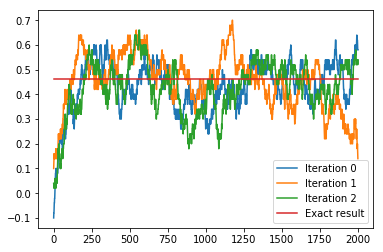

In [106]:
N = 2000

for i in range(3):
    lattice = Lattice(L = 10, B = 0.5)
    solver = Solver(lattice)

    M = []
    for lat in solver.iterate(N):
        M.append(lat.M)

    plt.plot(range(N), np.array(M)/100, label=f"Iteration {i}")

plt.plot((0, N), [np.tanh(0.5) for _ in range(2)], label=f"Exact result")
plt.legend()

#### 5b)
In the case of the figure above, we could say that $\kappa \approx 200$ steps. For larger $\left| B \right|$ this value will be larger, since it takes more steps of changing a single spin to reach a higher exact value.

#### 5c)
We will do 100 measurements with $L = 10$, $B = 0,5$, $N = 2000$. The computed magnetisation and standard deviation can be found below the code block.

In [107]:
N = 2000
exp = []
m2 = []

for _ in range(100):
    lattice = Lattice(L = 10, B = 0.5)
    solver = Solver(lattice)

    M = []
    for lat in solver.iterate(N):
        M.append(lat.M)

    M = M[200:]
    exp.append(1/len(M) * np.sum(M) / 100)      # L**2 = 100
    m2.append(1/len(M) * (np.sum(M)/100)**2)    # L**2 = 100

exp = np.array(exp)
m2 = np.array(m2)

print(f"Computed: m = {np.mean(exp)} ± {np.std(exp)} (standard deviation)")
print(f"   Exact: m = {np.tanh(0.5)}")

Computed: m = 0.457547888888889 ± 0.02311125869050103 (standard deviation)
   Exact: m = 0.46211715726000974


#### 5d)

Computed: m = 0.457547888888889 ± 0.4340559766022233 (delta m over average M)


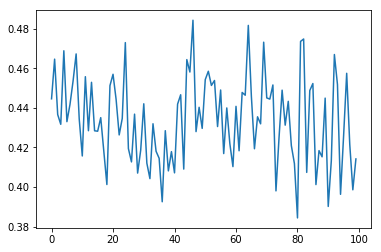

In [111]:
dm = np.sqrt((m2 - exp**2)/(N-1))
plt.plot(range(100), dm)

print(f"Computed: m = {np.mean(exp)} ± {np.mean(dm)} (delta m over average M)")